In [1]:
import os
import sys
import numpy as np

sys.path.append("src/")

In [2]:
# args for loading the model
# see main.py for more details regarding each argument here
class Args:
    gpu="1"
    net="resnet50"
    optimizer="adam"
    mode="adapt"
    dataset="flowers2"
    lr=0.0005
    warmup_ratio=0.0
    resume="models/adapt/meta/model.h5"
    batch_size=5
    epochs=36
    gmn_path="models/adapt/meta/model.h5"
    data_path="data/flowers/"
args = Args()

In [3]:
import utils as ut

# ==> gpu configuration
ut.initialize_GPU(args)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# ==> import library
import keras
import data_loader as data_loader
import model_factory as model_factory
import data_generator as data_generator
from matplotlib import pyplot as plt

Using TensorFlow backend.


## Load the model

In [5]:
# just for the sake of it

# ==> set up model path and log path.
model_path, log_path = ut.set_path(args)
# ==> get dataset information
trn_config = data_loader.get_config(args)
params = {'cg': trn_config,
              'processes': 12,
              'batch_size': args.batch_size
              }
trn_gen, val_gen = data_generator.setup_generator(**params)

In [6]:
# ==> load networks
# well that adapt argument gotta be true otherwise you won't be able to load the weights
gmn = model_factory.two_stream_matching_networks(trn_config, sync=False, adapt=True)
gmn.load_weights(args.gmn_path, by_name=True)

# ==> print model summary
gmn.summary()

==> successfully loaded pretrained resnet50
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_patch (InputLayer)        (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
resnet50_patchnet (Model)       (None, 4, 4, 512)    1538624     image_patch[0][0]                
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 512)          0           resnet50_patchnet[1][0]          
__________________________________________________________________________________________________
exemplar_l2 (L2_Normalization_L (None, 512)          1           global_average_pooling2d_1[0][0] 
_________________________________________________________________

## Load the image and preprocess

In [7]:
inp_img = ut.load_data('data/flowers/Images/15.jpg',dims=trn_config.imgdims, pad=trn_config.pad)
label = ut.load_dotlabel("data/flowers/image2/15.jpg", imgdims=trn_config.imgdims)
exempler_ = ut.sample_exemplar(inputs=(inp_img,label), patchdims=trn_config.patchdims, augment=False)
ex_patch = exempler_[0]
label = exempler_[1]

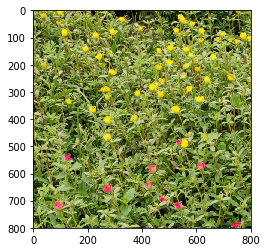

In [8]:
plt.imshow(inp_img)

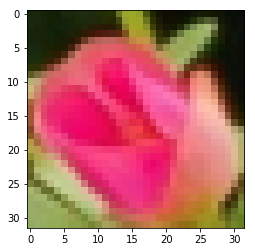

In [9]:
plt.imshow(ex_patch)

In [10]:
# preprocessing for the image
inp_img = np.expand_dims(inp_img, axis=0)
ex_patch = np.expand_dims(ex_patch, axis=0)
inp_img = data_generator.preprocess_input(np.array(inp_img, dtype='float32'))
ex_patch = data_generator.preprocess_input(np.array(ex_patch, dtype='float32'))
inputs = {'image_patch': ex_patch, 'image': inp_img}

## Prediction 

In [11]:
outputs = gmn.predict(inputs,batch_size=1)

In [12]:
outputs = np.squeeze(outputs,axis=0)
outputs = np.squeeze(outputs,axis=2)

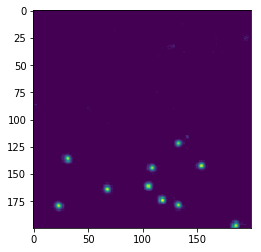

In [13]:
# predicted output
plt.imshow(outputs)

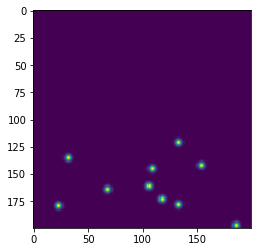

In [14]:
# ground truth
plt.imshow(label)

In [15]:
number_of_flowers = np.sum(outputs/100)
number_of_flowers

9.297085